# 1) Setup colab GPU runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=cfa093f33f66ba0f2ef00db9d2d22e9fd905e65bffdf1eee1e9e9643a6e66e32
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=8cf84201b56d1ad397afeec9ba8056af08930c5ba838ed4f10bfa1bd84490102
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

# 1.1. Download Dataset

Original dataset:
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 11.61 MiB/s, done.
Resolving deltas: 100% (3/3), done.


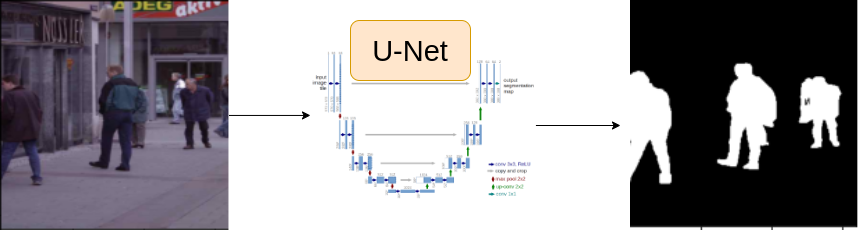

# 1.2. Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch # PyTorch library
import cv2 # OpenCV library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

# 2) Setup Configuration

In [5]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv' # Copy the path to the train.csv file inside the Human-Segmentation-Dataset-master folder
DATA_DIR = '/content/'

DEVICE = 'cuda' # GPU will be used for execution

EPOCHS = 25
LR = 0.003 # Learning Rate
IMAGE_SIZE = 320 # Height = Width
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
# Plot the image
df = pd.read_csv(CSV_FILE) # Data frame
df.head() # 'masks' are the target images (i.e. segments) and 'images' are the original input images

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[1]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert the image to RGB format

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0 # mask image will be a grayscale image and it is converted to a black and white image

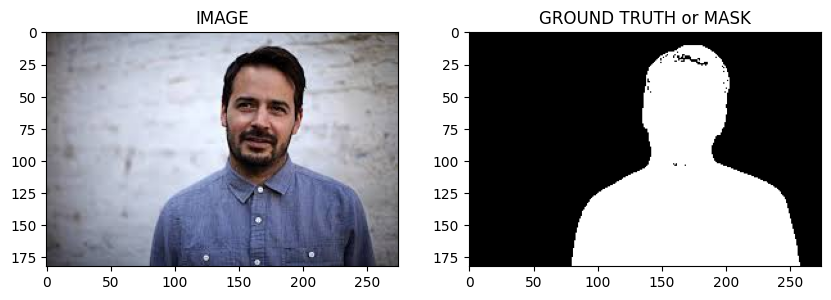

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH or MASK')
ax2.imshow(mask, cmap = 'gray')

In [9]:
# Split the data set into training and validate data sets
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# 3) Augmentation Functions

Albumentation documentation : https://albumentations.ai/docs/

In [10]:
# Augmentation brings variety in the data set;
# albumentation package is used for data augmentation and it can be applied to a variety of data sets for image segmentation, image object detection, image classification, etc.
# For segmentation data sets, any application of augmentation brings the same effect to both original and ground truth or mask images
import albumentations as A

In [29]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5), # 50% chance that the image will be flipped horizontally
      A.VerticalFlip(p = 0.5) # 50% chance that the image will be flipped vertically
      ], is_check_shapes=False)

def get_validate_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
      ], is_check_shapes=False)

# 4) Create Custom Dataset

In [30]:
# Custom data set is created to obtain an image-mask pair for the given index
from torch.utils.data import Dataset

In [31]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # image format = (height, width, channel) = axis(0, 1, 2)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # image format = (height, width, channel) = axis(0, 1, 2)
    mask = np.expand_dims(mask, axis = -1)
    if self.augmentations:
      data = self.augmentations(image = image, mask = mask) # This will return the mask and image as a dictionary
      image = data['image']
      mask = data['mask']
    # Change the format of the images to (channel, height, width)
    image = np.transpose(image, (2, 0, 1)).astype(np.float32) # 2, 0, 1 are the axis labeled for the input image and they are being reordered using transpose()
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)
    # Convert the images in numpy to Tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0) # Round the pixel values to either 0 or 1
    return image, mask

In [32]:
trainset = SegmentationDataset(train_df, get_train_augs())
validateset = SegmentationDataset(valid_df, get_validate_augs())

In [33]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validateset)}")

Size of Trainset : 232
Size of Validset : 58


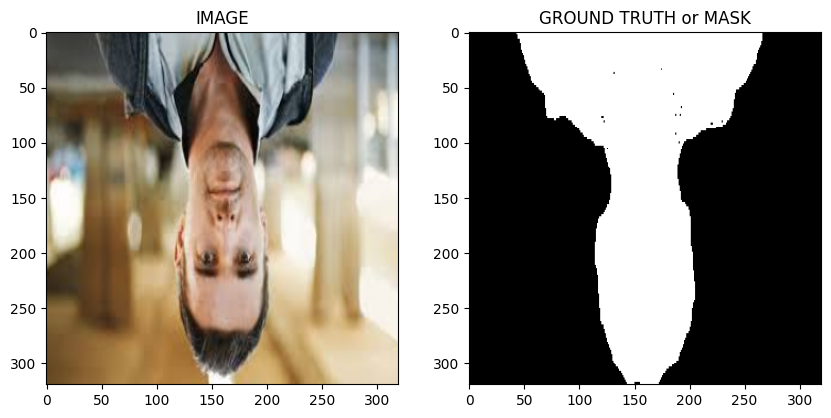

In [34]:
idx = 32

image, mask = trainset[idx]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image.permute(1,2,0).squeeze())

ax2.set_title('GROUND TRUTH or MASK')
ax2.imshow(mask.permute(1,2,0).squeeze(), cmap = 'gray')

# 5) Load Dataset into Batches

In [35]:
from torch.utils.data import DataLoader

In [36]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True) # At every Epoch, the batches get shuffled if 'shuffle' parameter is set to True
validloader = DataLoader(validateset, batch_size=BATCH_SIZE)

In [37]:
print(f"Total number of batches in trainloader: {len(trainloader)}") # Ceil(training set size / batch size)
print(f"Total number of batches in validloader: {len(validloader)}") # Ceil(validation set size / batch size)

Total number of batches in trainloader: 15
Total number of batches in validloader: 4


In [39]:
for image, mask in trainloader:
  break

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# 6) Create Segmentation Model

Segmentation Models PyTorch Documentation : https://smp.readthedocs.io/en/latest/

In [40]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [41]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
    # Unet segmentation model is used; Unet is convolution neural network for image semantic segmentation
    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3, # R G B channels
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)
    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks) # Binary cross entropy with logits loss
      return logits, loss1 + loss2
    return logits

In [42]:
model = SegmentationModel()
model.to(DEVICE) # Move to and run model on GPU using CUDA

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# 7) Create Training and Validation Functions

In [43]:
def training(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad() # Set gradients to be zeros
    logits, loss = model(images, masks) # Run the model (i.e. image segmentation model previously defined)
    loss.backward() # Compute gradients w.r.t the loss function; Do a backward pass
    optimizer.step() # Update the weights resulting in a gradient descent

    total_loss += loss.item()
  return total_loss / len(data_loader) # Return the average loss by dividing total_loss by number of batches

In [44]:
def validation(data_loader, model):
  model.eval() # Avoids using any dropout layer(s)
  total_loss = 0.0

  with torch.no_grad(): # Disable gradient computation
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()
  return total_loss / len(data_loader) # Return the average loss by dividing total_loss by number of batches


# 8) Train the Model

In [45]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [46]:
best_validation_loss = np.Inf # Set to infinity initially

for i in range(EPOCHS):
  train_loss = training(trainloader, model, optimizer)
  valid_loss = validation(validloader, model)
  if (valid_loss < best_validation_loss):
    torch.save(model.state_dict(), 'best_model.pt')
    print("Model Saved!")
    best_validation_loss = valid_loss

  print(f"Epoch: {i+1}, Training loss: {train_loss}, Validation loss: {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  5.84it/s]


Model Saved!
Epoch: 1, Training loss: 0.8346401214599609, Validation loss: 0.782890260219574


100%|██████████| 4/4 [00:00<00:00,  6.09it/s]


Epoch: 2, Training loss: 0.4449234247207642, Validation loss: 0.8105722367763519


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


Model Saved!
Epoch: 3, Training loss: 0.3142874290545781, Validation loss: 0.2642275243997574


100%|██████████| 4/4 [00:00<00:00,  5.87it/s]


Epoch: 4, Training loss: 0.3101310869057973, Validation loss: 0.3312762752175331


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Model Saved!
Epoch: 5, Training loss: 0.24463027119636535, Validation loss: 0.21841854229569435


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


Epoch: 6, Training loss: 0.22365819215774535, Validation loss: 0.2669871747493744


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


Epoch: 7, Training loss: 0.22143384714921316, Validation loss: 0.2533103749155998


100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


Epoch: 8, Training loss: 0.20355957349141438, Validation loss: 0.22290555387735367


100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Epoch: 9, Training loss: 0.18446150670448938, Validation loss: 0.22616363316774368


100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


Epoch: 10, Training loss: 0.19738054871559144, Validation loss: 0.2600390911102295


100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


Epoch: 11, Training loss: 0.15366476078828176, Validation loss: 0.23668155074119568


100%|██████████| 4/4 [00:00<00:00,  5.82it/s]


Model Saved!
Epoch: 12, Training loss: 0.13573667456706365, Validation loss: 0.19183827191591263


100%|██████████| 4/4 [00:00<00:00,  5.78it/s]


Epoch: 13, Training loss: 0.13586253076791763, Validation loss: 0.22172664105892181


100%|██████████| 4/4 [00:00<00:00,  5.62it/s]


Epoch: 14, Training loss: 0.146705162525177, Validation loss: 0.19477642327547073


100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


Epoch: 15, Training loss: 0.12593142092227935, Validation loss: 0.23543616384267807


100%|██████████| 4/4 [00:00<00:00,  4.94it/s]


Model Saved!
Epoch: 16, Training loss: 0.1327506721019745, Validation loss: 0.18577086180448532


100%|██████████| 4/4 [00:00<00:00,  5.82it/s]


Epoch: 17, Training loss: 0.146350134909153, Validation loss: 0.20165133476257324


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch: 18, Training loss: 0.12178644488255183, Validation loss: 0.1915658786892891


100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


Epoch: 19, Training loss: 0.12222593228022258, Validation loss: 0.25103795900940895


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch: 20, Training loss: 0.15140187243620554, Validation loss: 0.22359539195895195


100%|██████████| 4/4 [00:00<00:00,  5.87it/s]


Epoch: 21, Training loss: 0.12055682117740313, Validation loss: 0.23108961805701256


100%|██████████| 4/4 [00:00<00:00,  5.79it/s]


Epoch: 22, Training loss: 0.11266268094380696, Validation loss: 0.23998147994279861


100%|██████████| 4/4 [00:00<00:00,  5.92it/s]


Epoch: 23, Training loss: 0.10089379400014878, Validation loss: 0.22229263186454773


100%|██████████| 4/4 [00:00<00:00,  5.83it/s]


Epoch: 24, Training loss: 0.10228631844123205, Validation loss: 0.22986871004104614


100%|██████████| 4/4 [00:00<00:00,  5.87it/s]

Epoch: 25, Training loss: 0.09545473456382751, Validation loss: 0.2140209786593914


# 9) Inference

In [48]:
# Inference using best saved model i.e. best_model.pt
idx = 20

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validateset[idx] # image tensor has shape of (channel, height, width)

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # Unsqueeze to add the batch dimension so that image tensor's shape becomes (1, channel, height, width)

predicted_mask = torch.sigmoid(logits_mask) # Apply sigmoid activation
predicted_mask = (predicted_mask > 0.5)*1.0

<ipython-input-48-fffd2d898af3>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pt'))


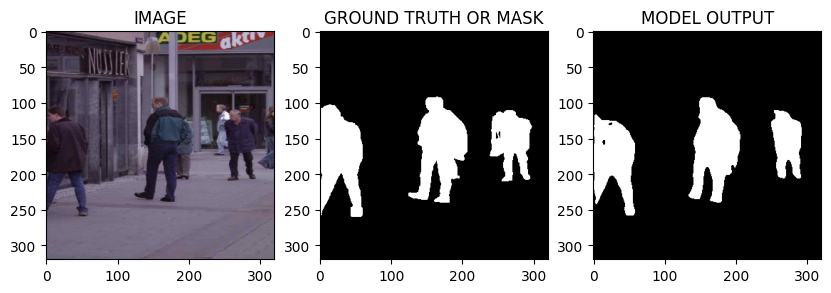

In [50]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

ax2.set_title('GROUND TRUTH OR MASK')
ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

ax3.set_title('MODEL OUTPUT')
predicted_mask = predicted_mask.detach().cpu().squeeze(0)
ax3.imshow(predicted_mask.permute(1,2,0).squeeze(),cmap = 'gray')

In [51]:
idx = 2

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validateset[idx] # image tensor has shape of (channel, height, width)

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # Unsqueeze to add the batch dimension so that image tensor's shape becomes (1, channel, height, width)

predicted_mask = torch.sigmoid(logits_mask) # Apply sigmoid activation
predicted_mask = (predicted_mask > 0.5)*1.0

<ipython-input-51-fcc7e3591c8b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pt'))


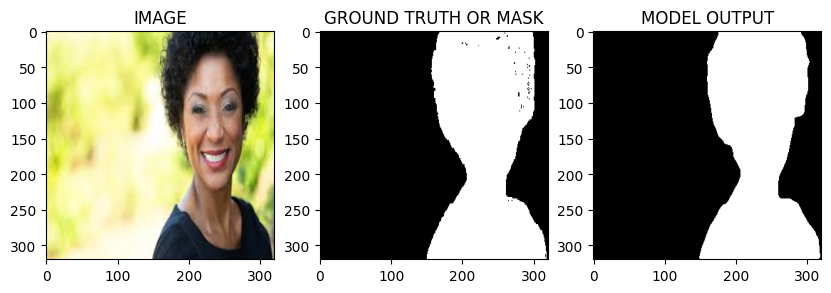

In [52]:
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

ax2.set_title('GROUND TRUTH OR MASK')
ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

ax3.set_title('MODEL OUTPUT')
predicted_mask = predicted_mask.detach().cpu().squeeze(0)
ax3.imshow(predicted_mask.permute(1,2,0).squeeze(),cmap = 'gray')